## Getting Started

We start off by defining the necessary imports for this notebook.

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Flatten, Concatenate, Input
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

from sklearn.preprocessing import MinMaxScaler

Next, we'll mount Google Drive to load the data files while ensuring persistence of storage.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We can now begin by loading the training data from `train.csv`.

In [ ]:
# Load training data
df = pd.read_csv("drive/MyDrive/DataCrunch/train.csv")

df.head()

,ID,Year,Month,Day,kingdom,latitude,longitude,Avg_Temperature,Avg_Feels_Like_Temperature,Temperature_Range,Feels_Like_Temperature_Range,Radiation,Rain_Amount,Rain_Duration,Wind_Speed,Wind_Direction,Evapotranspiration
0,1,1,4,1,Arcadia,24.280002,-37.229980,25.50,30.50,8.5,10.3,22.52,58.89,16,8.6,283,1.648659
1,2,1,4,1,Atlantis,22.979999,-37.329990,299.65,305.15,5.9,8.2,22.73,11.83,12,15.8,161,1.583094
2,3,1,4,1,Avalon,22.880000,-37.130006,26.30,31.50,5.2,6.4,22.73,11.83,12,15.8,161,1.593309
3,4,1,4,1,Camelot,24.180003,-36.929994,24.00,28.40,8.2,10.7,22.67,75.27,16,6.4,346,1.638997
4,5,1,4,1,Dorne,25.780002,-37.530000,28.00,32.80,5.7,10.2,22.35,4.81,8,16.7,185,1.719189


## Exploratory Data Analysis

A good way to start off EDA is by inspecting the shape of our dataframe.

In [ ]:
# Get shape of data
df.shape

(84960, 17)

Here, we can see that our dataframe has:

1. 84,960 samples (rows)
2. 17 features (columns)

We can get more information related to the data, such as the data types of the features, missing values etc. using `df.info()`.

In [ ]:
# Get overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84960 entries, 0 to 84959
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            84960 non-null  int64  
 1   Year                          84960 non-null  int64  
 2   Month                         84960 non-null  int64  
 3   Day                           84960 non-null  int64  
 4   kingdom                       84960 non-null  object 
 5   latitude                      84960 non-null  float64
 6   longitude                     84960 non-null  float64
 7   Avg_Temperature               84960 non-null  float64
 8   Avg_Feels_Like_Temperature    84960 non-null  float64
 9   Temperature_Range             84960 non-null  float64
 10  Feels_Like_Temperature_Range  84960 non-null  float64
 11  Radiation                     84960 non-null  float64
 12  Rain_Amount                   84960 non-null  float64
 13  R

The output of `df.info()` yields the following information:

1. We only have one categorical variable - `kingdom` i.e. the names of the kingdoms of Harveston. The rest of the variables are continuous - either integer or float.
2. There appears to be no missing values in any of the columns of the dataframe.

Additional, we can also get a **statistical summary** of our data using `df.describe()`.

In [ ]:
# Get statistical summary of data
df.describe()

,ID,Year,Month,Day,latitude,longitude,Avg_Temperature,Avg_Feels_Like_Temperature,Temperature_Range,Feels_Like_Temperature_Range,Radiation,Rain_Amount,Rain_Duration,Wind_Speed,Wind_Direction,Evapotranspiration
count,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000,84960.000000
mean,42480.500000,4.610876,6.666667,15.735876,24.003334,-37.266665,135.600751,139.735375,5.345287,6.361224,20.338598,7.723850,8.895680,15.629291,215.831297,1.568724
std,24525.983772,2.239331,3.402793,8.802867,0.798622,0.488873,133.650417,133.937168,1.977739,2.371880,4.118938,13.477186,7.231531,6.198760,93.917858,0.219856
min,1.000000,1.000000,1.000000,1.000000,22.880000,-37.729980,18.600000,18.700000,0.500000,0.800000,3.190000,0.000000,0.000000,2.300000,0.000000,0.425268
25%,21240.750000,3.000000,4.000000,8.000000,23.680003,-37.630006,26.300000,30.300000,3.800000,4.500000,18.070000,0.520000,2.000000,11.100000,119.000000,1.451614
50%,42480.500000,5.000000,7.000000,16.000000,23.780002,-37.530000,28.100000,32.500000,5.100000,6.200000,20.960000,3.380000,8.000000,15.100000,255.000000,1.589235
75%,63720.250000,7.000000,10.000000,23.000000,24.280002,-37.130006,299.350000,303.850000,6.500000,8.000000,23.300000,9.490000,15.000000,19.000000,286.000000,1.715598
max,84960.000000,8.000000,12.000000,31.000000,26.580005,-35.729980,303.650000,309.650000,15.400000,17.300000,30.100000,440.440000,24.000000,50.200000,359.000000,2.212660


An important verification we need to do is to check the unique values of the `Year`, `Month` and `Day` columns, to make sure they don't include any weird and unexpected information (e.g. a `Day` that's not between 1 and 31).

In [ ]:
date_cols = ["Year", "Month", "Day"]

for col in date_cols:
  # Retrieve list of unique values for `Year` column
  unique_values = df[col].unique()

  # Display result
  print(f"Unique values of `{col}` column: {unique_values}")

Unique values of `Year` column: [1 2 3 4 5 6 7 8]
Unique values of `Month` column: [ 4  5  6  7  8  9 10 11 12  1  2  3]
Unique values of `Day` column: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


In [ ]:
# Convert all temperatures > 100 from Kelvin to Celsius

df['Avg_Temperature'] = df['Avg_Temperature'].apply(
    lambda x: x - 273.15 if x > 100 else x
)

df['Avg_Feels_Like_Temperature'] = df['Avg_Feels_Like_Temperature'].apply(
    lambda x: x - 273.15 if x > 100 else x
)

In [ ]:
# Define threshold value for identifying outliers
threshold = 1.5

# Iterate over the columns in the dataset
for column in df.columns:
    # Select columns that do not contain categorical data
    if df[column].dtype != "object":
        # Get first quartile
        Q1 = df[column].quantile(0.25)

        # Get third quartile
        Q3 = df[column].quantile(0.75)

        # Get IQR of particular column
        IQR = Q3 - Q1

        # Identify outliers
        outliers = df[((df[column] < Q1 - threshold * IQR) | (df[column] > Q3 + threshold * IQR))]

        # NOTE
        # `outliers` itself is a dataframe. Therefore, to get the number of rows
        # that are outliers, we can use `len(outliers)`

        print(f"Outliers for {column}: {len(outliers)}")

Outliers for ID: 0
Outliers for Year: 0
Outliers for Month: 0
Outliers for Day: 0
Outliers for latitude: 8496
Outliers for longitude: 8496
Outliers for Avg_Temperature: 5880
Outliers for Avg_Feels_Like_Temperature: 4769
Outliers for Temperature_Range: 1163
Outliers for Feels_Like_Temperature_Range: 303
Outliers for Radiation: 2031
Outliers for Rain_Amount: 6564
Outliers for Rain_Duration: 0
Outliers for Wind_Speed: 1989
Outliers for Wind_Direction: 0
Outliers for Evapotranspiration: 2297


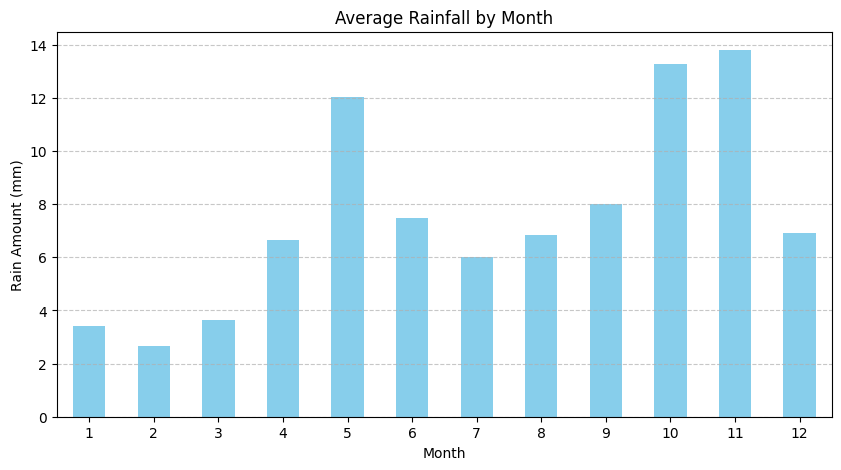

In [ ]:
# Group by Month and calculate mean rain
monthly_rain = df.groupby('Month')['Rain_Amount'].mean()

# Plot
plt.figure(figsize=(10, 5))
monthly_rain.plot(kind='bar', color='skyblue')
plt.title('Average Rainfall by Month')
plt.xlabel('Month')
plt.ylabel('Rain Amount (mm)')
plt.xticks(rotation=0)  # Keep month numbers horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

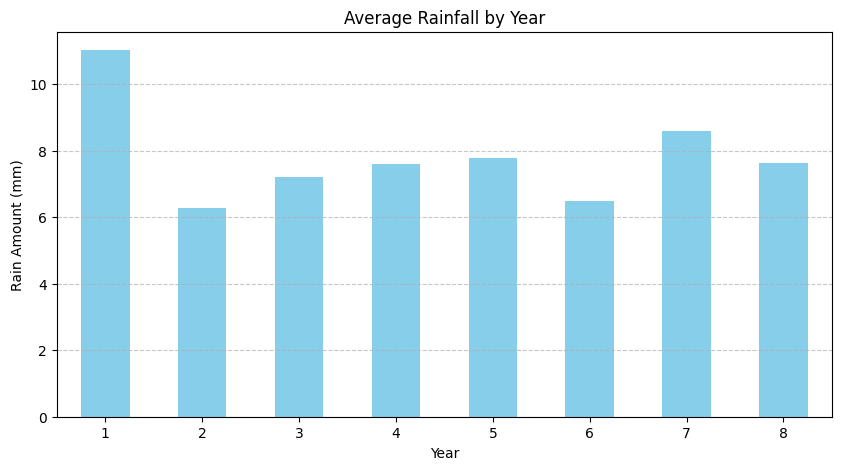

In [ ]:
# Group by Year and calculate mean rain
monthly_rain = df.groupby('Year')['Rain_Amount'].mean()

# Plot
plt.figure(figsize=(10, 5))
monthly_rain.plot(kind='bar', color='skyblue')
plt.title('Average Rainfall by Year')
plt.xlabel('Year')
plt.ylabel('Rain Amount (mm)')
plt.xticks(rotation=0)  # Keep year numbers horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

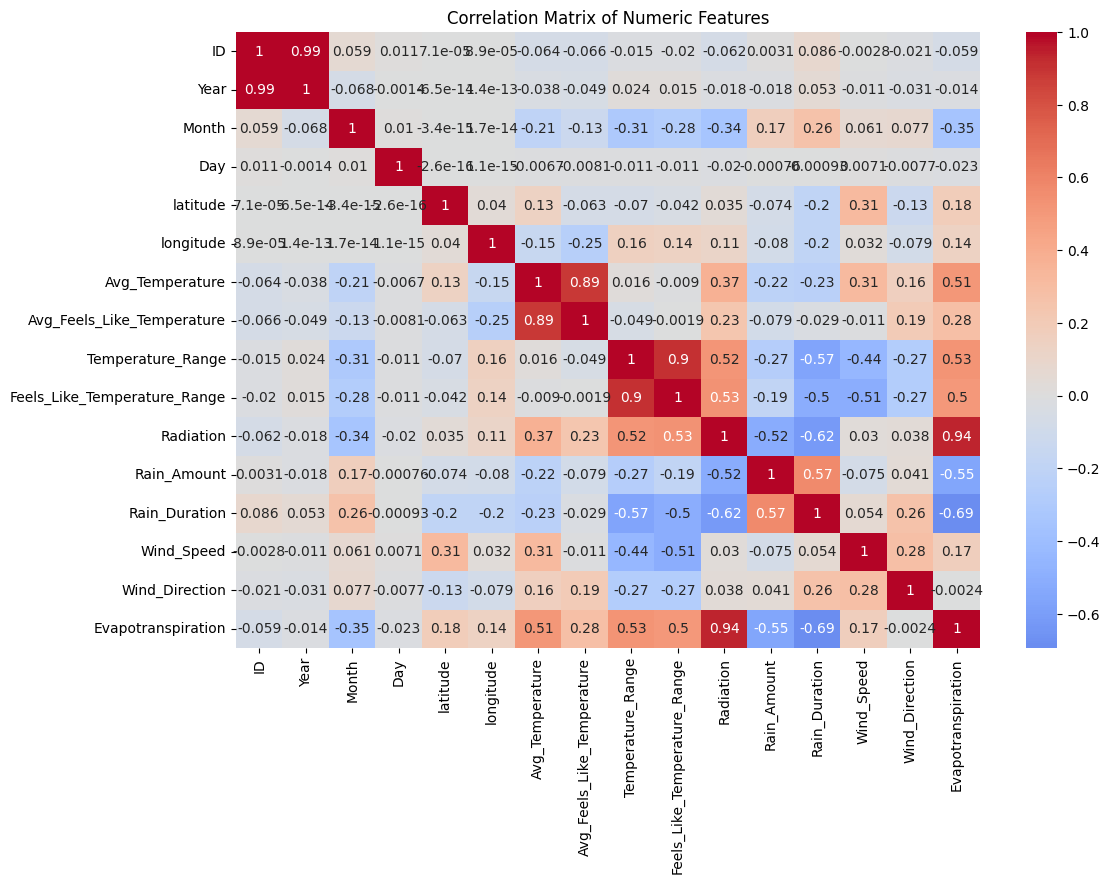

In [ ]:
# Select numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

We must also engineer a feature called `Date`, since we need a single datetime feature for time-series datasets. We can make this feature using the existing `Year`, `Month` and `Day` features.

However, since the values of `Year` are between 1 and 8, we'll set a baseline year (say, 2000) and add that to each value of the `Year` column. This way, the dates will make more sense.

In [ ]:
# Assume the earliest year is 2000
base_year = 2000

# Create `Date` feature from date information
df['Date'] = pd.to_datetime(
    (df['Year'] + base_year).astype(str) + '-' +
    df['Month'].astype(str) + '-' +
    df['Day'].astype(str),
    format='%Y-%m-%d',
    errors='coerce'  # Handle invalid dates (e.g., Feb 30)
)

df.head()

,ID,Year,Month,Day,kingdom,latitude,longitude,Avg_Temperature,Avg_Feels_Like_Temperature,Temperature_Range,Feels_Like_Temperature_Range,Radiation,Rain_Amount,Rain_Duration,Wind_Speed,Wind_Direction,Evapotranspiration,Date
0,1,1,4,1,Arcadia,24.280002,-37.229980,25.5,30.5,8.5,10.3,22.52,58.89,16,8.6,283,1.648659,2001-04-01
1,2,1,4,1,Atlantis,22.979999,-37.329990,26.5,32.0,5.9,8.2,22.73,11.83,12,15.8,161,1.583094,2001-04-01
2,3,1,4,1,Avalon,22.880000,-37.130006,26.3,31.5,5.2,6.4,22.73,11.83,12,15.8,161,1.593309,2001-04-01
3,4,1,4,1,Camelot,24.180003,-36.929994,24.0,28.4,8.2,10.7,22.67,75.27,16,6.4,346,1.638997,2001-04-01
4,5,1,4,1,Dorne,25.780002,-37.530000,28.0,32.8,5.7,10.2,22.35,4.81,8,16.7,185,1.719189,2001-04-01


In [ ]:
#Cyclical encoding for Month
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# day-of-year cyclical features from the Date column
df['day_of_year'] = df['Date'].dt.dayofyear
df['dayofyear_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

df.head()

,ID,Year,Month,Day,kingdom,latitude,longitude,Avg_Temperature,Avg_Feels_Like_Temperature,Temperature_Range,...,Rain_Duration,Wind_Speed,Wind_Direction,Evapotranspiration,Date,month_sin,month_cos,day_of_year,dayofyear_sin,dayofyear_cos
0,1,1,4,1,Arcadia,24.280002,-37.229980,25.5,30.5,8.5,...,16,8.6,283,1.648659,2001-04-01,0.866025,-0.5,91.0,0.999991,0.004304
1,2,1,4,1,Atlantis,22.979999,-37.329990,26.5,32.0,5.9,...,12,15.8,161,1.583094,2001-04-01,0.866025,-0.5,91.0,0.999991,0.004304
2,3,1,4,1,Avalon,22.880000,-37.130006,26.3,31.5,5.2,...,12,15.8,161,1.593309,2001-04-01,0.866025,-0.5,91.0,0.999991,0.004304
3,4,1,4,1,Camelot,24.180003,-36.929994,24.0,28.4,8.2,...,16,6.4,346,1.638997,2001-04-01,0.866025,-0.5,91.0,0.999991,0.004304
4,5,1,4,1,Dorne,25.780002,-37.530000,28.0,32.8,5.7,...,8,16.7,185,1.719189,2001-04-01,0.866025,-0.5,91.0,0.999991,0.004304


In [ ]:
# Drop redundant columns
df = df.drop(['ID', 'Avg_Feels_Like_Temperature', 'Feels_Like_Temperature_Range', 'latitude', 'longitude','Rain_Duration', 'Evapotranspiration','Temperature_Range', 'Year', 'Month', 'Day'], axis=1)

# Handle NaNs from lag/rolling operations
df = df.dropna()

# Final check
print(df.columns)

Index(['kingdom', 'Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed',
       'Wind_Direction', 'Date', 'month_sin', 'month_cos', 'day_of_year',
       'dayofyear_sin', 'dayofyear_cos'],
      dtype='object')


In [ ]:
# Sort by date (critical for time-series)
df = df.sort_values('Date').reset_index(drop=True)

# Define split point (e.g., last 20% as test data)
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

In [ ]:
# Encode kingdoms as unique IDs
kingdom_to_id = {k: i for i, k in enumerate(train_df["kingdom"].unique())}
train_df["Kingdom_ID"] = train_df["kingdom"].map(kingdom_to_id)
test_df["Kingdom_ID"] = test_df["kingdom"].map(kingdom_to_id)  # Map test kingdoms

# Drop unnecessary columns
train_features = train_df.drop(columns=["Date", "kingdom"])  # Drop non-numeric columns
test_features = test_df.drop(columns=["Date", "kingdom"])    # Same for test

<ipython-input-44-32cf922dc4ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Kingdom_ID"] = train_df["kingdom"].map(kingdom_to_id)
<ipython-input-44-32cf922dc4ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Kingdom_ID"] = test_df["kingdom"].map(kingdom_to_id)  # Map test kingdoms


In [ ]:
# Target variables
target_cols = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']
# Feature variables (excluding Date and Kingdom text column)
feature_cols = [col for col in df.columns if col not in target_cols + ["Date", "kingdom"]]
print(feature_cols)

# Reorder DataFrame to place targets last
train_df = train_df[feature_cols + ["Kingdom_ID"]+ target_cols ]
test_df = test_df[feature_cols + ["Kingdom_ID"]+ target_cols ]

train_df.head()

# Separate features and targets for training and testing datasets
train_features = train_df[feature_cols + ["Kingdom_ID"]]
train_targets  = train_df[target_cols]

test_features  = test_df[feature_cols + ["Kingdom_ID"]]
test_targets   = test_df[target_cols]

['month_sin', 'month_cos', 'day_of_year', 'dayofyear_sin', 'dayofyear_cos']


In [ ]:
# Scale the features separately
feature_scaler = MinMaxScaler(feature_range=(0, 1))
train_features_scaled = feature_scaler.fit_transform(train_features)
test_features_scaled  = feature_scaler.transform(test_features)

In [ ]:
# Scale the target variables separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
train_targets_scaled = target_scaler.fit_transform(train_targets)
test_targets_scaled  = target_scaler.transform(test_targets)

In [ ]:
# Combine scaled features and targets for sequence creation
train_scaled = np.hstack((train_features_scaled, train_targets_scaled))
test_scaled = np.hstack((test_features_scaled, test_targets_scaled))

In [ ]:
def create_sequences(data, kingdom_ids, time_steps, n_targets=5):
    """
    Converts time-series data into sequences for LSTM.
    Each sample contains `time_steps` worth of data and predicts the next time step.
    """
    X_seq, X_kingdom, y_seq = [], [], []

    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i+time_steps, :-n_targets])  # Use all features except last `n_targets`
        X_kingdom.append(kingdom_ids[i+time_steps])      # Kingdom ID for the predicted time step
        y_seq.append(data[i+time_steps, -n_targets:])    # Predicting next-step target variables

    return np.array(X_seq), np.array(X_kingdom), np.array(y_seq)

time_steps = 1  # Look-back window

# Prepare training and testing sets
X_train_seq, X_train_kingdom, y_train = create_sequences(train_scaled, train_df["Kingdom_ID"].values, time_steps)
X_test_seq, X_test_kingdom, y_test = create_sequences(test_scaled, test_df["Kingdom_ID"].values, time_steps)

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)

In [ ]:
print(y_train.shape, X_train_seq.shape)

def build_model(hp):
    # Fixed parameters
    num_kingdoms = len(kingdom_to_id)
    num_features = X_train_seq.shape[2]
    num_targets = y_train.shape[1]

    # Tunable parameters
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    embedding_dim = hp.Int('embedding_dim', min_value=2, max_value=8, step=2)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Inputs
    sequence_input = Input(shape=(time_steps, num_features), name='sequence_input')
    kingdom_input = Input(shape=(1,), name='kingdom_input')

    # Kingdom Embedding
    kingdom_embedding = Embedding(input_dim=num_kingdoms, output_dim=embedding_dim, name='kingdom_embedding')(kingdom_input)
    kingdom_embedding_flat = Flatten(name='flatten_kingdom')(kingdom_embedding)

    # LSTM Model
    lstm_out = LSTM(lstm_units, activation='relu', name='lstm_layer')(sequence_input)
    lstm_out = Dropout(dropout_rate, name='dropout_layer')(lstm_out)
    lstm_out = Dense(dense_units, activation='relu', name='dense_layer')(lstm_out)

    # Concatenate
    concatenated = Concatenate(name='concatenate')([lstm_out, kingdom_embedding_flat])

    # Output Layer
    output = Dense(num_targets, name='output_layer')(concatenated)

    # Define model
    model = Model(inputs=[sequence_input, kingdom_input], outputs=output)

    # Compile model with tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse'
    )

    return model

(67919, 5) (67919, 1, 6)


In [ ]:
# Create a Bayesian Optimization tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='hyperparameter_tuning',
    project_name='lstm_kingdom_prediction'
)

# Define early stopping for each trial
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Print search space summary
tuner.search_space_summary()

# Run the search
tuner.search(
    [X_train_seq, X_train_kingdom], y_train,
    validation_data=([X_test_seq, X_test_kingdom], y_test),
    epochs=30,  # Maximum epochs per trial
    batch_size=32,
    callbacks=[early_stopping]
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print results
print("Best Hyperparameters:")
print(f"LSTM Units: {best_hps.get('lstm_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 02m 57s]
val_loss: 0.013863394036889076

Best val_loss So Far: 0.013863394036889076
Total elapsed time: 00h 20m 02s
Best Hyperparameters:
LSTM Units: 32
Dropout Rate: 0.30000000000000004
Dense Units: 16
Embedding Dimension: 6
Learning Rate: 0.00019188694664461315


In [ ]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

# Train the best model with early stopping
final = best_model.fit(
    [X_train_seq, X_train_kingdom], y_train,
    epochs=50,
    batch_size=32,
    validation_data=([X_test_seq, X_test_kingdom], y_test),
    callbacks=[early_stopping]
)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequence_input            │ (None, 1, 6)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer (LSTM)         │ (None, 32)             │          4,992 │ sequence_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ kingdom_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_layer (Dropout)   │ (None, 32)             │              0 │ lstm_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ kingdom_embedding         │ (None, 1, 6)           │            180 │ kingdom_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_layer (Dense)       │ (None, 16)             │            528 │ dropout_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_kingdom (Flatten) │ (None, 6)              │              0 │ kingdom_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 22)             │              0 │ dense_layer[0][0],     │
│                           │                        │                │ flatten_kingdom[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 5)              │            115 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,815 (22.71 KB)

 Trainable params: 5,815 (22.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.1008 - val_loss: 0.0153
Epoch 2/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0157 - val_loss: 0.0142
Epoch 3/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 4/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0136 - val_loss: 0.0141
Epoch 5/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0134 - val_loss: 0.0141
Epoch 6/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0133 - val_loss: 0.0141
Epoch 7/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0131 - val_loss: 0.0140
Epoch 8/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0130 - val_loss: 0.0141
Epoch 9/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0130 - val_loss: 0.0140
Epoch 10/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0129 - val_loss: 0.0140
Epoch 11/50
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 12/50
2123/2123 ━━━━━

In [ ]:
best_model.save("drive/MyDrive/DataCrunch/model.keras")

# **Load and get predictions**

In [ ]:
df = pd.read_csv("drive/MyDrive/DataCrunch/test.csv")

In [ ]:
model = load_model("drive/MyDrive/DataCrunch/model.keras")

In [ ]:
# Assume the earliest year is 2000
base_year = 2000

# Create `Date` feature from date information
df['Date'] = pd.to_datetime(
    (df['Year'] + base_year).astype(str) + '-' +
    df['Month'].astype(str) + '-' +
    df['Day'].astype(str),
    format='%Y-%m-%d',
    errors='coerce'  # Handle invalid dates (e.g., Feb 30)
)

df.head()

,ID,Year,Month,Day,kingdom,Date
0,84961,9,1,1,Arcadia,2009-01-01
1,84962,9,1,1,Atlantis,2009-01-01
2,84963,9,1,1,Avalon,2009-01-01
3,84964,9,1,1,Camelot,2009-01-01
4,84965,9,1,1,Dorne,2009-01-01


In [ ]:
#Cyclical encoding for Month
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# day-of-year cyclical features from the Date column
df['day_of_year'] = df['Date'].dt.dayofyear
df['dayofyear_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

df.head()

,ID,Year,Month,Day,kingdom,Date,month_sin,month_cos,day_of_year,dayofyear_sin,dayofyear_cos
0,84961,9,1,1,Arcadia,2009-01-01,0.5,0.866025,1,0.017213,0.999852
1,84962,9,1,1,Atlantis,2009-01-01,0.5,0.866025,1,0.017213,0.999852
2,84963,9,1,1,Avalon,2009-01-01,0.5,0.866025,1,0.017213,0.999852
3,84964,9,1,1,Camelot,2009-01-01,0.5,0.866025,1,0.017213,0.999852
4,84965,9,1,1,Dorne,2009-01-01,0.5,0.866025,1,0.017213,0.999852


In [ ]:
df['Kingdom_ID'] = df['kingdom'].map(kingdom_to_id)

In [ ]:
new_df = df.copy()

df = df.drop(['Year', 'Month', 'Day', 'kingdom','Date','ID'], axis=1)
df.head()

,month_sin,month_cos,day_of_year,dayofyear_sin,dayofyear_cos,Kingdom_ID
0,0.5,0.866025,1,0.017213,0.999852,0
1,0.5,0.866025,1,0.017213,0.999852,18
2,0.5,0.866025,1,0.017213,0.999852,19
3,0.5,0.866025,1,0.017213,0.999852,20
4,0.5,0.866025,1,0.017213,0.999852,21


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
test_scaled = scaler.fit_transform(df)

print(test_scaled.shape)

(4530, 6)


In [ ]:
def create_sequences_test(data, kingdom_ids, time_steps, n_features=6):
    """
    For test data (no target variables).
    Uses ALL columns as features (no exclusion of targets).
    """
    X_seq, X_kingdom = [], []

    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i+time_steps, :n_features])  # Use all features (no target exclusion)
        X_kingdom.append(kingdom_ids[i+time_steps])      # Kingdom ID for the predicted time step

    return np.array(X_seq), np.array(X_kingdom)

In [ ]:
time_steps = 1  # Must match the training configuration

X_test_seq, X_test_kingdom = create_sequences_test(
    data=test_scaled,
    kingdom_ids=df["Kingdom_ID"].values,
    time_steps=time_steps
)


print(X_test_seq.shape)

(4529, 1, 6)


In [ ]:
predictions = model.predict([X_test_seq, X_test_kingdom])

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
predictions= target_scaler.inverse_transform(predictions)

pred_df = pd.DataFrame(predictions, columns=[
    "Avg_Temperature", "Radiation", "Rain_Amount", "Wind_Speed", "Wind_Direction"
])


final_df = pd.concat(
    [new_df[["ID"]], pred_df],
    axis=1
)

final_df.head()

final_df.to_csv("drive/MyDrive/DataCrunch/sample_submission.csv", index=False)